# Gradient-Effected Object Recognition Gauge for hive Entrances (GEORGE)
Neural-net-powered honeybee hive-mounted pollen, varroa, and wasp counter

## Imports

In [1]:
import os
import matplotlib.pyplot as plt
import random
import glob
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import argparse
import tensorflow as tf
from statistics import mean
import GEORGE_Library as GEORGE
%matplotlib inline

print("Done")

Done


In [2]:
category_index = {1: {'id': 1, 'name': 'none'}, 2: {'id': 2, 'name': 'pollen'}, 3: {'id': 3, 'name': 'varroa'}, 4: {'id': 4, 'name': 'wasps'}}
train_augmented_fp = "Dataset/TrainAugmented"
val_augmented_fp = "Dataset/ValAugmented"
IMAGE_WIDTH = 75
IMAGE_HEIGHT = 150
EX_SUB = False
VAL_SIZE = 0.1
FILL_IMG = True
num_sets = 2

def auto_canny(image, sigma=0.6):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv2.Canny(image, lower, upper)
	# return the edged image
	return edged

def expand_img(image):
    b_list = []
    g_list = []
    r_list = []

    for row in image:
        for pixel in row:
            for k, value in enumerate(pixel):
                if k == 0:
                    b_list.append(value)
                if k == 1:
                    g_list.append(value)
                if k == 2:
                    r_list.append(value)
    max_list = [max(b_list), max(g_list), max(r_list)]
    min_list = [min(b_list), min(g_list), min(r_list)]
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            for k, value in enumerate(pixel):
                image[i][j][k] = (value - min_list[k]) * (255 / max_list[k])
    return(image)

print("Done")

Done


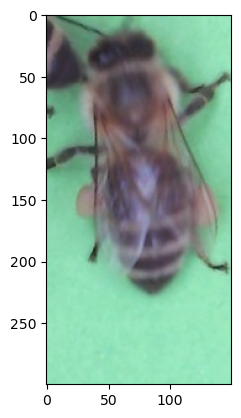

In [13]:
# Get Image
dataset_paths = {'PD': {'none': {'path': 'Dataset/PollenDataset/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/PollenDataset/Pollen', 'label': [1, 0, 0]}},
                 'BA': {'none': {'path': 'Dataset/BeeAlarmed/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/BeeAlarmed/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/BeeAlarmed/Varroa', 'label': [0, 1, 0]},
                        'wasps': {'path': 'Dataset/BeeAlarmed/Wasps', 'label': [0, 0, 1]}},
                 'YM': {'none': {'path': 'Dataset/YangModel/None', 'label': [0, 0, 0]},
                        'pollen': {'path': 'Dataset/YangModel/Pollen', 'label': [1, 0, 0]},
                        'varroa': {'path': 'Dataset/YangModel/Varroa', 'label': [0, 1, 0]}}}#,

train_random_file_list = []
val_random_file_list = []
file_list = []
for dataset_path in dataset_paths:
    for dataset in dataset_paths[dataset_path]:
        [file_list.append(i) for i in glob.glob(dataset_paths[dataset_path][dataset]['path'] + '/*')]
p = np.random.permutation(len(file_list))
train_random_file_list = [file_list[i] for i in p[0:(round(len(file_list) * (1 - VAL_SIZE)))]]
val_random_file_list = [file_list[i] for i in p[(round(len(file_list) * (1 - VAL_SIZE))):len(file_list)]]

filename = glob.glob(dataset_paths['BA']['pollen']['path'] + '/*')[3]
image = Image.open(filename)

# Check size
if max(image.size) < min(IMAGE_WIDTH, IMAGE_HEIGHT):
    ind = (image.size).index(max(image.size))
    size = np.zeros(2)
    size[ind] = min(IMAGE_WIDTH, IMAGE_HEIGHT)
    size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
    image = image.resize((round(size[0]), round(size[1])))
elif min(image.size) > max(IMAGE_WIDTH, IMAGE_HEIGHT):
    ind = (image.size).index(min(image.size))
    size = np.zeros(2)
    size[ind] = max(IMAGE_WIDTH, IMAGE_HEIGHT)
    size[1 - ind] = (size[ind] / image.size[ind]) * image.size[1 - ind]
    image = image.resize((round(size[0]), round(size[1])))
if np.array(image).max() <= 1:
    image = np.array(image) * 255

plt.imshow(image)
plt.show()

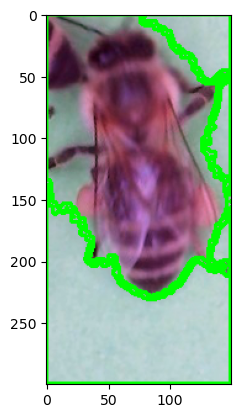

In [15]:
# Perform Augmentation
new_image = expand_img(np.array(image))
disp_image = new_image

# convert to gray
gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)[1]

# morphology edgeout = dilated_mask - mask
# morphology dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

# get absolute difference between dilate and thresh
diff = cv2.absdiff(dilate, thresh)

disp_image = diff
# invert
new_image = 255 - diff

# # define a (3, 3) structuring element
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# # apply the dilation operation to the edged image
# dilate = cv2.dilate(canny_result, kernel, iterations=6)

contours, _ = cv2.findContours(new_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
blank = np.ones(np.shape(new_image))
#outline = cv2.drawContours(blank, contours, -1, (0, 255, 0), 2)
outline = cv2.drawContours(np.array(image), contours, -1, (0, 255, 0), 2)
plt.imshow(outline)
plt.show()


    
# b = cv2.blur(np.array(image.copy())[:,:,0],(3,3))
# g = cv2.blur(np.array(image.copy())[:,:,1],(3,3))
# r = cv2.blur(np.array(image.copy())[:,:,2],(3,3))
# b = GEORGE.automatic_brightness_and_contrast(np.array(b).astype('uint8'))
# g = GEORGE.automatic_brightness_and_contrast(np.array(g).astype('uint8'))
# r = GEORGE.automatic_brightness_and_contrast(np.array(r).astype('uint8'))
# b = auto_canny(b)
# g = auto_canny(g)
# r = auto_canny(r)

# canny_result = cv2.copyMakeBorder(b+g+r, 20, 20, 20, 20, cv2.BORDER_CONSTANT, None, value = 0)
# plt.imshow(canny_result)
# #plt.imshow(auto_canny(np.array(new_image)))

# plt.show()
# # define a (3, 3) structuring element
# kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# # apply the dilation operation to the edged image
# dilate = cv2.dilate(canny_result, kernel, iterations=6)

# # find the contours in the dilated image
# contours, _ = cv2.findContours(dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# blank = np.ones(np.shape(canny_result))b
# outline = cv2.drawContours(blank, contours, -1, (0, 255, 0), 2)
# contract_outline = cv2.erode(outline, kernel, iterations=6)
# print(outline)
# plt.imshow(outline)
# plt.show()
# # plt.imshow(contract_outline)
# # new_image = 255 - diffplt.show()
# #             # new_image = GEORGE.automatic_brightness_and_contrast(np.array(new_image).astype('uint8'))
# #             # new_image = GEORGE.zoom_image(new_image)
# #             # if EX_SUB:
# #             #     new_image = GEORGE.extract_sub(np.array(new_image).astype('uint8'))
# # print("Done")

In [30]:

# if EX_SUB:
#     # new_image = GEORGE.extract_sub(np.array(new_image).astype('uint8'))

#     # read image
#     # img = cv2.imread("cartoon.jpg")

#     # convert to gray
#     gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)

#     # threshold
#     thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)[1]

#     # morphology edgeout = dilated_mask - mask
#     # morphology dilate
#     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
#     dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

#     # get absolute difference between dilate and thresh
#     diff = cv2.absdiff(dilate, thresh)

#     # invert
#     new_image = 255 - diff

#     cv2.imshow("edges", new_image)
#     cv2.waitKey(0)

## Let's just visualize the images as a sanity check

<function matplotlib.pyplot.show(close=None, block=None)>

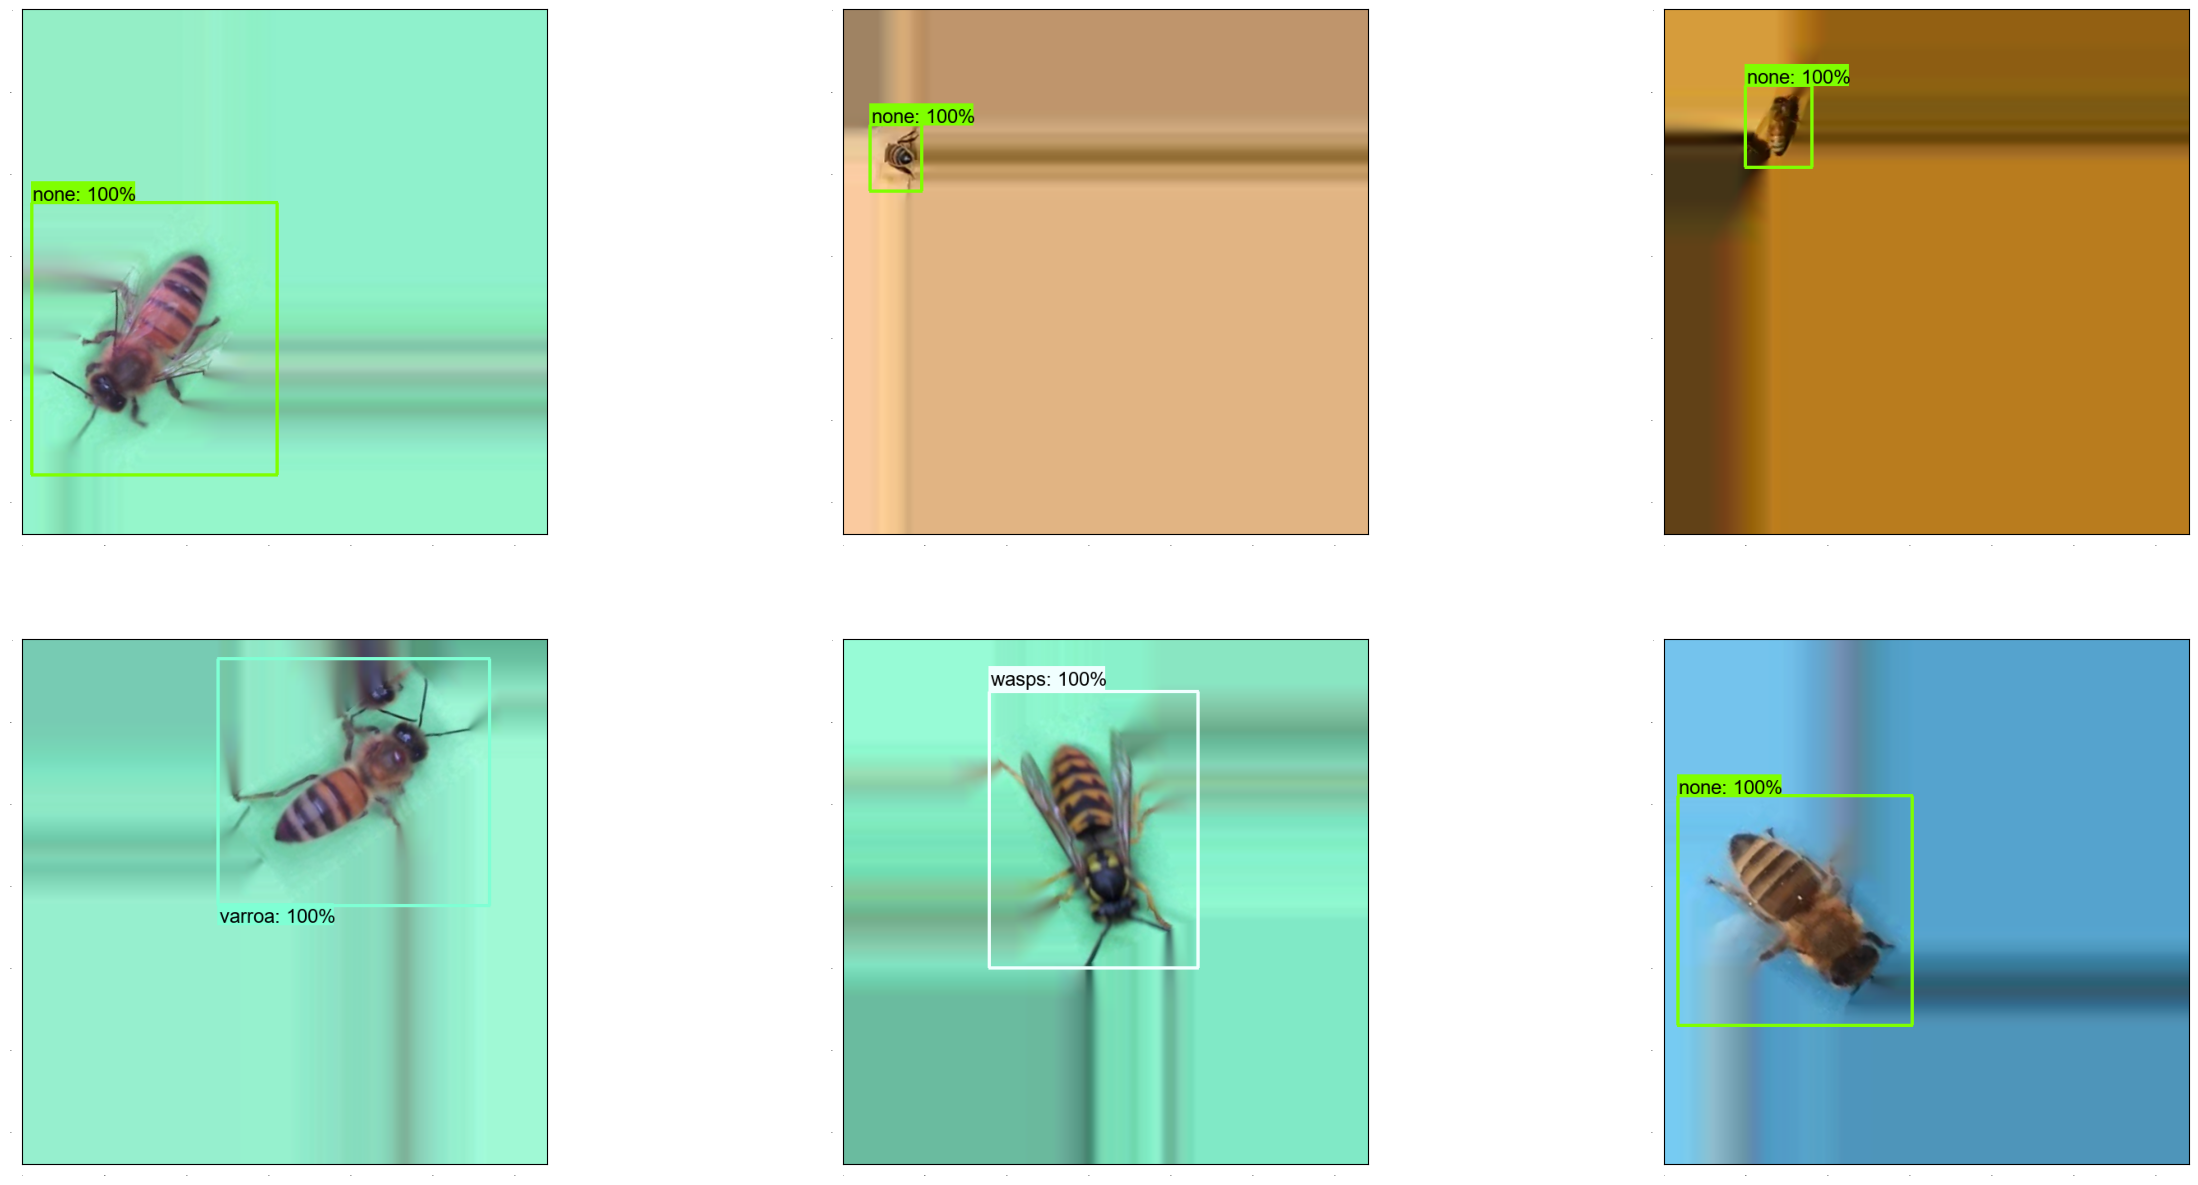

In [4]:
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [30, 15]

enum_file_subset = []
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

for i in range(6):
    rand_enum_val = random.randint(0, len(glob.glob(train_augmented_fp + '/*')))
    enum_file_subset.append(glob.glob(train_augmented_fp + '/*')[rand_enum_val])

for idx, filename in enumerate(enum_file_subset):
    plt.subplot(2, 3, idx+1)
    image, label, gt_box = GEORGE.get_file_and_info(filename)
    
    GEORGE.plot_detections(
        image,
        gt_box,
        np.array(label[2]),
        dummy_scores,
        category_index)
plt.show